In [1195]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack

In [1196]:
def processing_of_signal(input, weights):
    output = np.zeros_like(input)
    number_of_weights = weights.size

    for i in range(output.size - number_of_weights + 1):
        output[number_of_weights - 1 + i] = (input[i:number_of_weights + i] * weights).sum()

    return output

In [1197]:
def fitting_of_weights(number_of_weights, mu_0, epsilon):
    # weights = np.random.random(number_of_weights)
    weights = np.ones(number_of_weights)
    
    for i in range(len(second_output[number_of_weights - 1:])):
        first_input_k = first_input[i:number_of_weights + i]
        second_output_k = second_output[i + number_of_weights - 1]

        mu_k = mu_0 / ((first_input_k ** 2).sum() + epsilon)
        # mu_k = 0.01

        p = second_output_k * first_input_k

        r = np.empty((number_of_weights, number_of_weights))

        for i in range(number_of_weights):
            for j in range(number_of_weights):
                r[i, j] = first_input_k[i] * first_input_k[j]

        grad_J = -2 * (p - r.dot(weights))

        weights -= mu_k * grad_J
        
    return weights

In [1198]:
def noise_out(time_counts):
    return 2 * np.sin(2 * np.pi * 10 * time_counts)

In [1199]:
def noise_in(time_counts):
    return 0.5 * noise_out(time_counts)

In [1200]:
def useful_signal(time_counts):
    return 10 * np.sin(2 * np.pi * 1 * time_counts)

In [1201]:
right_bound = 10
number_of_point = 100000
t = np.linspace(0, right_bound, number_of_point, endpoint=False)

first_input = noise_out(t)

# в случае решения задачи шумоподавления
# second_output = noise_in(t) + useful_signal(t)

Промоделируем выходной сигнал такими весами

In [1202]:
processing_weights = np.array([0.1, 0.3, 0.5])

In [1203]:
second_output = processing_of_signal(first_input, processing_weights)

Входной и выходной сигнал на адаптивный фильтр

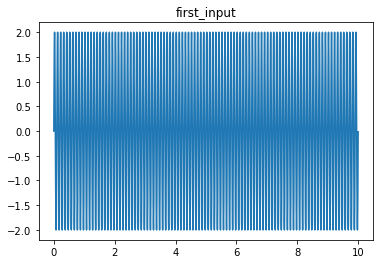

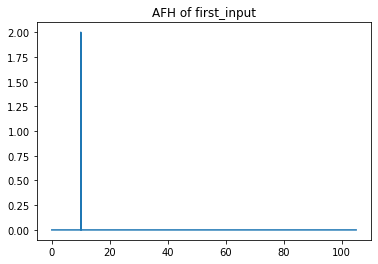

In [1204]:
plt.plot(t, first_input)
plt.title("first_input")
plt.show()

freq_bound = 2100

x = fftpack.rfftfreq(first_input.size, right_bound / number_of_point)[:freq_bound]
y = 2 * np.abs(fftpack.rfft(first_input)[:freq_bound]) / first_input.size

plt.plot(x, y)
plt.title("AFH of first_input")
plt.show()

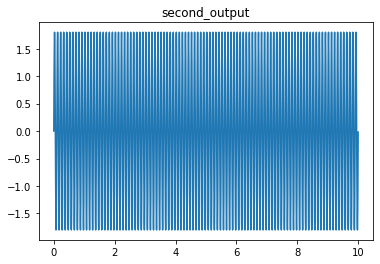

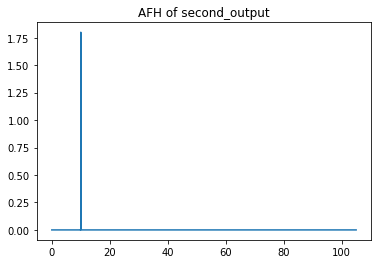

In [1205]:
plt.plot(t, second_output)
plt.title("second_output")
plt.show()

freq_bound = 2100

x = fftpack.rfftfreq(second_output.size, right_bound / number_of_point)[:freq_bound]
y = 2 * np.abs(fftpack.rfft(second_output)[:freq_bound]) / second_output.size

plt.plot(x, y)
plt.title("AFH of second_output")
plt.show()

Определим длину вектора высовых коэффициентов свертки, которыми мы будем апроксимировать АЧХ исходной системы

In [1206]:
number_of_weights = 3

Выведим полученные коэффициенты свертки

In [1207]:
approx_weights = fitting_of_weights(number_of_weights, 1, 1)
print(approx_weights)

[0.10832424 0.29945142 0.49060625]


Построим сигнал по найденным весам

In [1208]:
approx_signal = processing_of_signal(first_input, approx_weights)

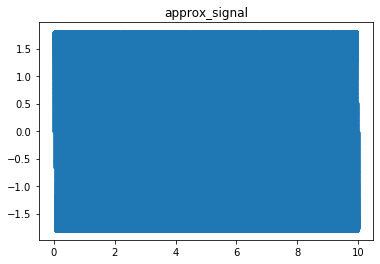

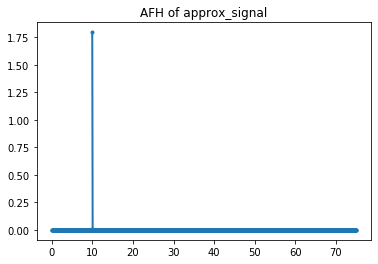

In [1216]:
plt.plot(t, approx_signal, ".")
plt.title("approx_signal")
plt.show()

freq_bound = 1500

x = fftpack.rfftfreq(approx_signal.size, right_bound / number_of_point)[:freq_bound]
y = 2 * np.abs(fftpack.rfft(approx_signal)[:freq_bound]) / approx_signal.size

plt.plot(x, y, ".-")
plt.title("AFH of approx_signal")
plt.show()

Рассмотрим АЧХ исходной и полученной передаточной функции

In [1210]:
# all_spectrum = np.zeros(t.size)
# all_spectrum[int(t.size / 2)] = 1

all_spectrum = np.zeros(100)
all_spectrum[50] = 1

In [1211]:
initial_weights_signal = processing_of_signal(all_spectrum, processing_weights)

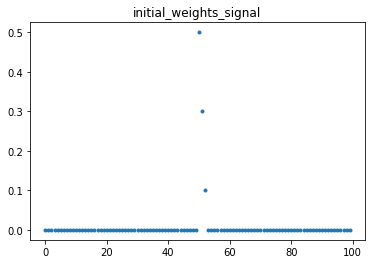

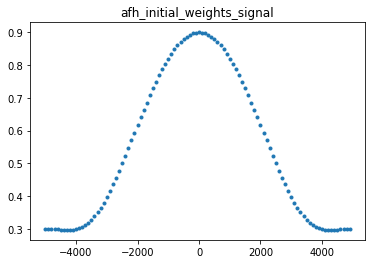

In [1212]:
plt.plot(np.arange(100), initial_weights_signal, ".")
plt.title("initial_weights_signal")
plt.show()

freq_bound = 1500

initial_fx = fftpack.fftfreq(initial_weights_signal.size, right_bound / number_of_point)[:freq_bound]
initial_fy = np.abs(fftpack.fft(initial_weights_signal)[:freq_bound])

plt.plot(initial_fx, initial_fy, ".")
plt.title("afh_initial_weights_signal")
plt.show()

In [1213]:
approx_weights_signal = processing_of_signal(all_spectrum, approx_weights)

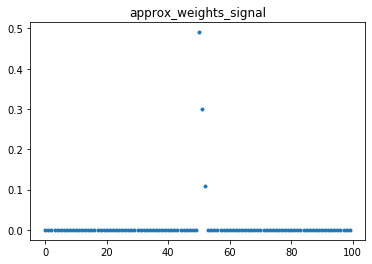

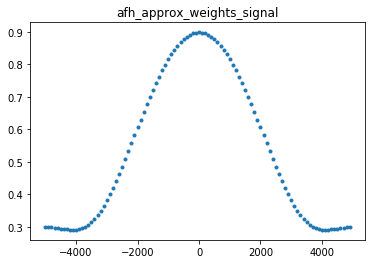

In [1214]:
plt.plot(np.arange(100), approx_weights_signal, ".")
plt.title("approx_weights_signal")
plt.show()

freq_bound = 1500

approx_fx = fftpack.fftfreq(approx_weights_signal.size, right_bound / number_of_point)[:freq_bound]
approx_fy = np.abs(fftpack.fft(approx_weights_signal)[:freq_bound])

plt.plot(approx_fx, approx_fy, ".")
plt.title("afh_approx_weights_signal")
plt.show()

Наложим их АЧХ друг на друга

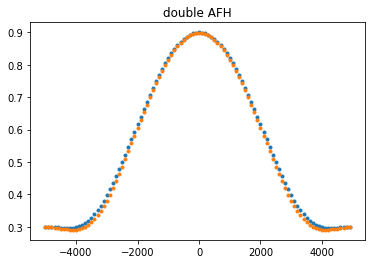

In [1215]:
plt.plot(initial_fx, initial_fy, ".")
plt.plot(approx_fx, approx_fy, ".")
plt.title("double AFH")

plt.show()